<a href="https://colab.research.google.com/github/victoruwazurike1/Hamoye_Internship_Notebooks/blob/main/hamoye_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv( "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv" ) 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
# Let us convert the Month column to datetime
df['Month'] = pd.to_datetime(df['Month'])

In [4]:
df.set_index('Month', inplace=True)

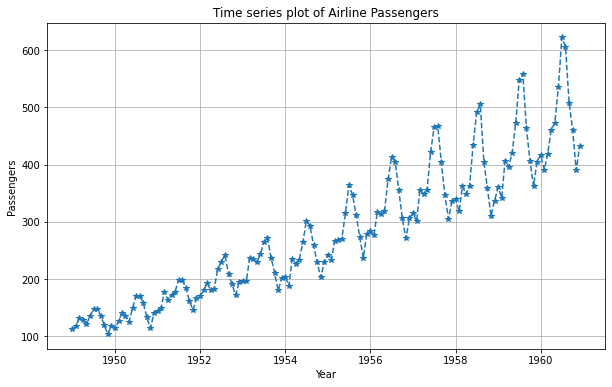

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker = '*')
plt.grid()
plt.title('Time series plot of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

In [6]:
# Let us check for missing values
df.isnull().values.any()

False

In [7]:
# There are no missing values in our dta but to show how to handle missing values 
# we will create another dataframe with missing values
df_copy = df.copy()
rows = df_copy.sample(frac=0.1, random_state=0)
rows['Passengers'] = np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()
# This will create 14 missing values in the new dataframe 

Passengers    14
dtype: int64

In [8]:
# Let us try filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method = 'ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

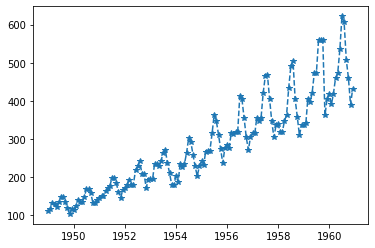

In [9]:
plt.plot(df.index, df_copy_ffill.Passengers, '--', marker = '*')

In [10]:
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

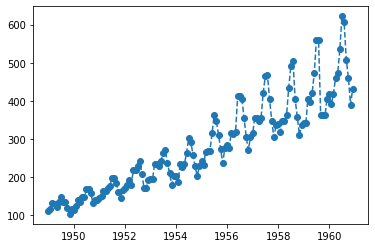

In [11]:
plt.plot(df.index, df_copy_bfill.Passengers, '--', marker = 'o')

In [12]:
# Let us also try filling missing dta by interpolation(forward and backward)
df_copy_LIF = df_copy.interpolate(method = 'linear', limit_direction = 'forward')
df_copy_LIF.isnull().sum()

Passengers    0
dtype: int64

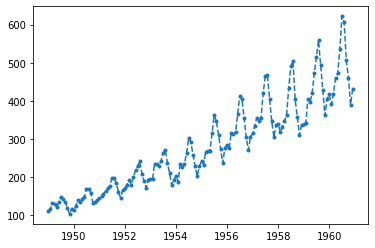

In [13]:
plt.plot(df.index, df_copy_LIF.Passengers, '--', marker = '.')

In [14]:
df_copy_LIB = df_copy.interpolate(method = 'linear', limit_direction = 'backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

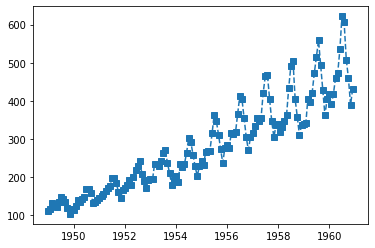

In [15]:
plt.plot(df.index, df_copy_LIB.Passengers, '--', marker = 's')

Downsampling and Upsampling

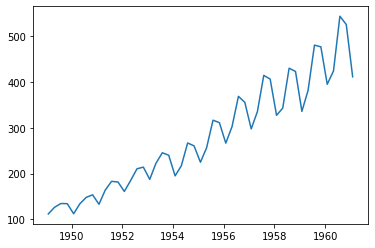

In [16]:
# Downsample to quarterly data points
df_quarterly = df.resample( '3M' ).mean()
plt.plot(df_quarterly)

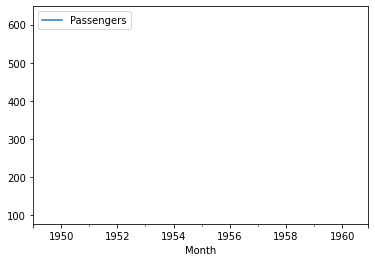

In [17]:
df_daily = df.resample('D').mean()
df_daily.plot()

In [18]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4353 entries, 1949-01-01 to 1960-12-01
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  144 non-null    float64
dtypes: float64(1)
memory usage: 68.0 KB


In [19]:
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

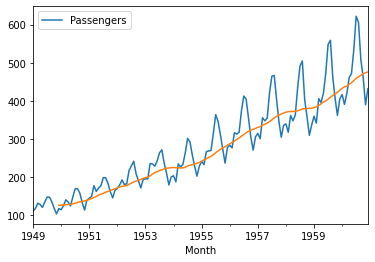

In [20]:
df_MA.plot()
MA.plot()

Time Series Specific Exploratory Methods

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


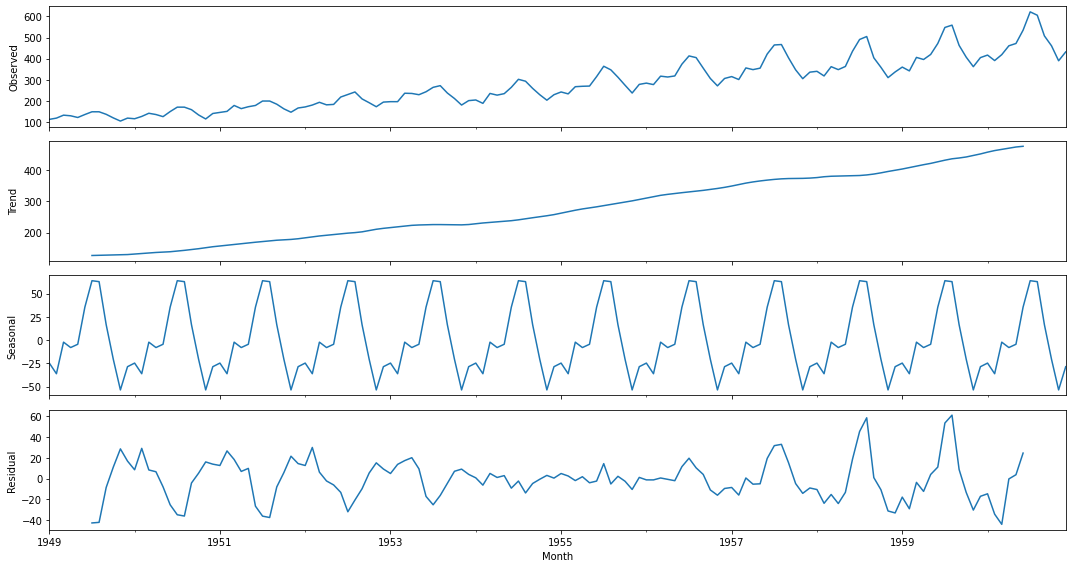

In [21]:
import statsmodels.api as sm
from pylab import rcParams
rcParams[ 'figure.figsize' ] = 15 , 8 
decompose_series = sm.tsa.seasonal_decompose(df[ 'Passengers' ], model= 'additive' ) 
decompose_series.plot() 
plt.show()

The decomposed time series show an obvious increasing trend and seasonality variations.
Recall that we have initially plotted the moving average on the last 12 months which showed
that it varies with time. This suggests that the data is not stationary. We will now perform
an ADF test to confirm this speculation 

In [22]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[ 0 ]} ' )
print(f'p-value: {adf_result[ 1 ]} ' )
print(f'No. of lags used: {adf_result[ 2 ]} ' )
print(f'No. of observations used : {adf_result[ 3 ]} ' )
print('Critical Values:' )
for k, v in adf_result[ 4 ].items():
  print( f' {k} : {v} ' )

ADF Statistic: 0.8153688792060472 
p-value: 0.991880243437641 
No. of lags used: 13 
No. of observations used : 130 
Critical Values:
 1% : -3.4816817173418295 
 5% : -2.8840418343195267 
 10% : -2.578770059171598 


From the results obtained, the p-value is greater than the critical value at a 5% significance level and, the ADF statistic is greater that any of the critical values obtain. This confirms that the series is indeed non-stationary. 

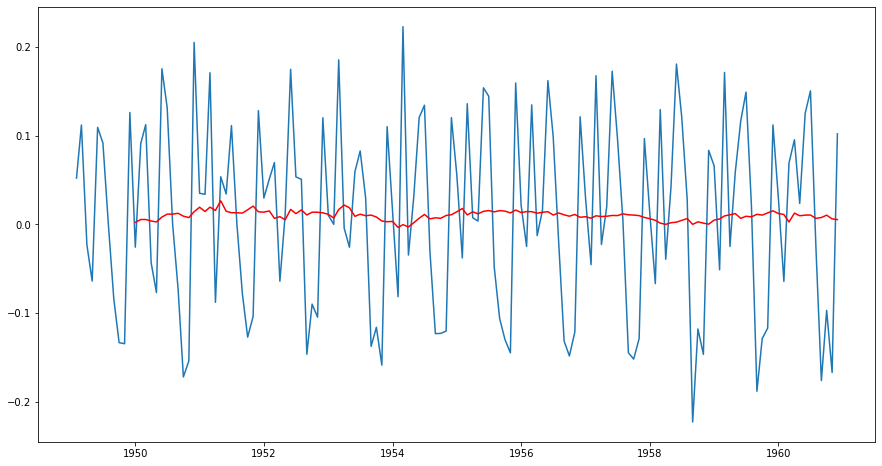

In [23]:
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing

df_log = np.log(df)
df_diff = df_log.diff(periods= 1 )
plt.plot(df_diff.index, df_diff.Passengers, '-' )
plt.plot(df_diff.rolling( 12 ).mean(), color= 'red' ) 

In [24]:
df_diff = df_diff.drop('1949-01-01')

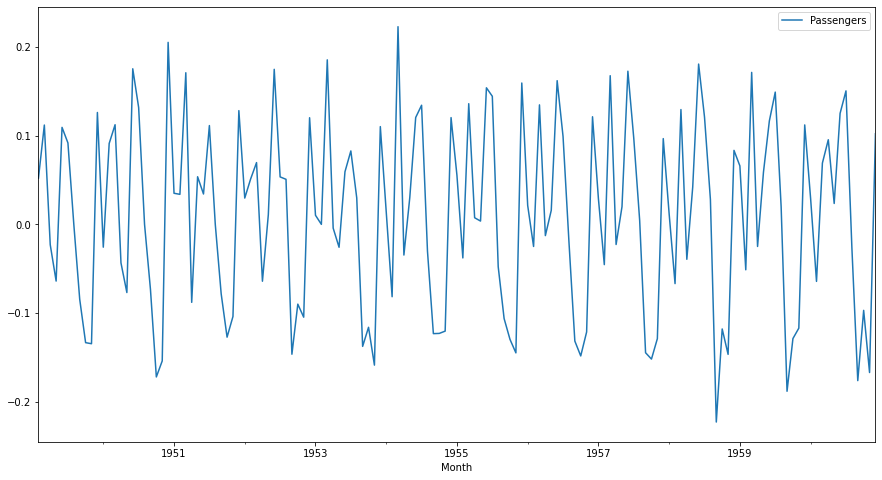

In [25]:
df_diff.plot()

Time series forecasting using Stochastic models

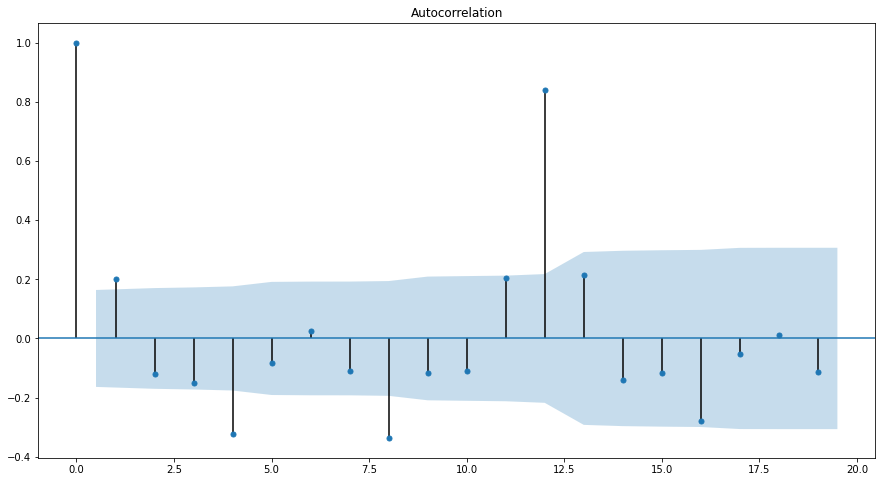

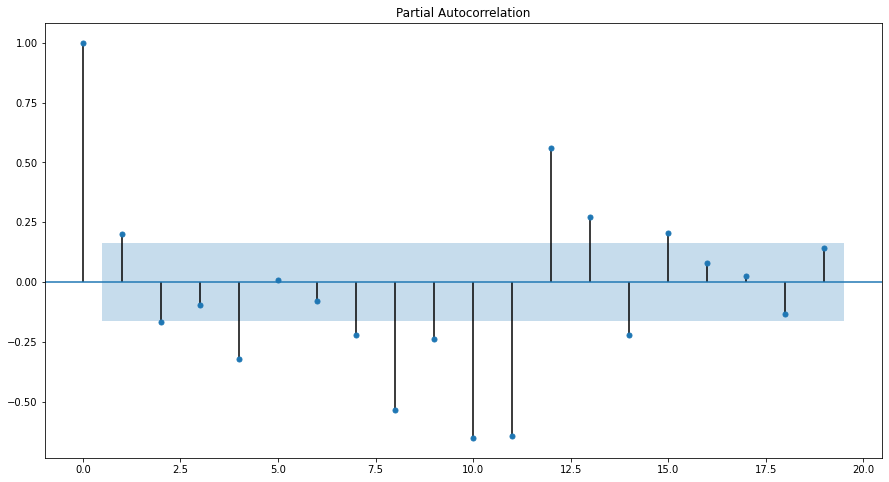

In [26]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(df_diff, lags = range(0,20))
plt.show()
#PACF
plot_pacf(df_diff, lags = range(0,20))
plt.show() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


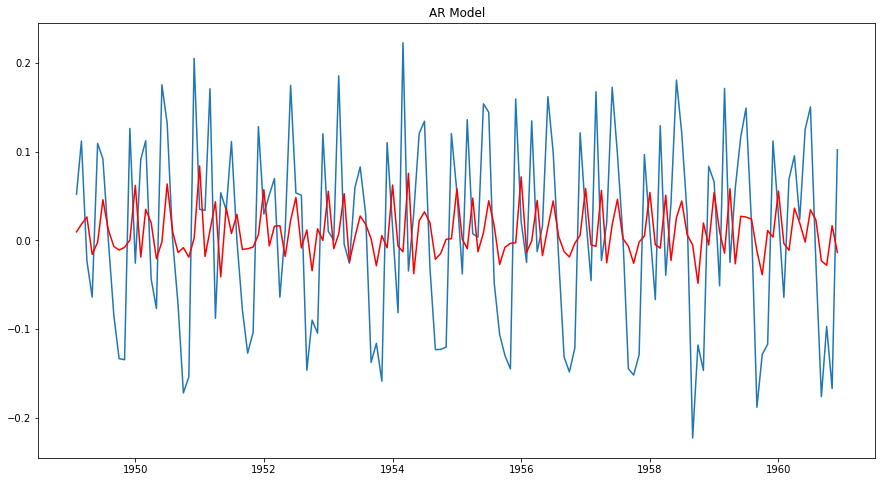

In [32]:
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.title('AR Model')
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color= 'red' )

In [28]:
df_diff.isnull()

,Passengers
Month,
1949-02-01,False
1949-03-01,False
1949-04-01,False
1949-05-01,False
1949-06-01,False
...,...
1960-08-01,False
1960-09-01,False
1960-10-01,False


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


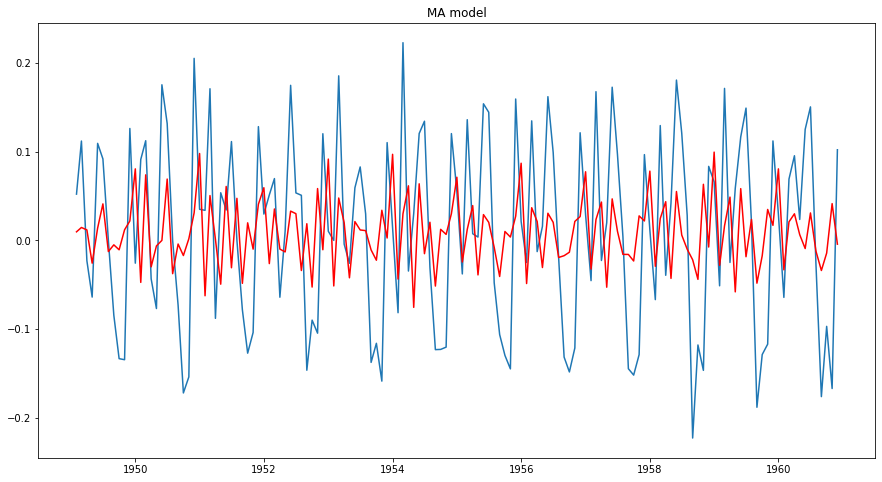

In [33]:
MA_model = ARIMA(df_diff, order=( 0 , 0 , 2 ))
MA_model_results = MA_model.fit()
plt.title('MA model')
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color= 'red' )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


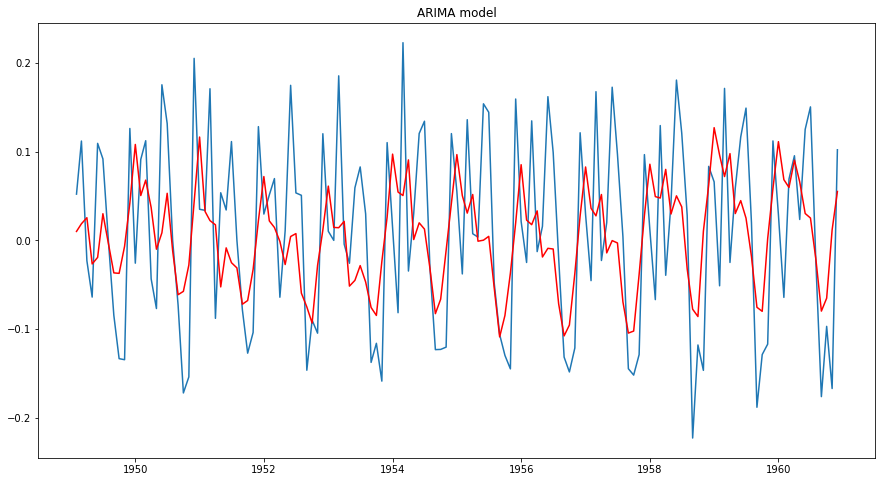

In [34]:
ARIMA_model = ARIMA(df_diff, order=( 2 , 0 , 1 )) 
ARIMA_results = ARIMA_model.fit()
plt.title('ARIMA model')
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color= 'red' )

In [35]:
from fbprophet import Prophet

In [39]:
data=pd.read_csv( "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv" ) 
data = data.rename(columns={ "Month" : "ds" , "Passengers" : "y" })
data.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [40]:
model = Prophet()
model.fit(data)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
#predict for the next 10 months
future = model.make_future_dataframe(periods= 10 , freq= 'M' )
forecast = model.predict(future)
forecast.head()
forecast[[ 'ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper' ]]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,1949-01-01,84.807353,57.496652,113.268284,106.727984,106.727984,106.727984
1,1949-02-01,78.218354,50.012282,108.290691,108.901201,108.901201,108.901201
2,1949-03-01,110.361397,82.457045,139.727513,110.864107,110.864107,110.864107
3,1949-04-01,107.851823,78.105918,136.875174,113.037323,113.037323,113.037323
4,1949-05-01,111.351735,82.310813,140.113329,115.140437,115.140437,115.140437
...,...,...,...,...,...,...,...
149,1961-05-31,533.992919,504.422584,563.346445,502.558318,502.405284,502.727999
150,1961-06-30,577.062353,546.541818,605.028221,505.571811,505.356927,505.804290
151,1961-07-31,575.495626,548.248906,604.912706,508.685754,508.414939,508.976805
152,1961-08-31,529.069236,499.419681,559.193032,511.799697,511.467252,512.165913


In [43]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.727984,57.496652,113.268284,106.727984,106.727984,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,0.0,0.0,0.0,84.807353
1,1949-02-01,108.901201,50.012282,108.290691,108.901201,108.901201,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,0.0,0.0,0.0,78.218354
2,1949-03-01,110.864107,82.457045,139.727513,110.864107,110.864107,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,0.0,0.0,0.0,110.361397
3,1949-04-01,113.037323,78.105918,136.875174,113.037323,113.037323,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,0.0,0.0,0.0,107.851823
4,1949-05-01,115.140437,82.310813,140.113329,115.140437,115.140437,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,0.0,0.0,0.0,111.351735


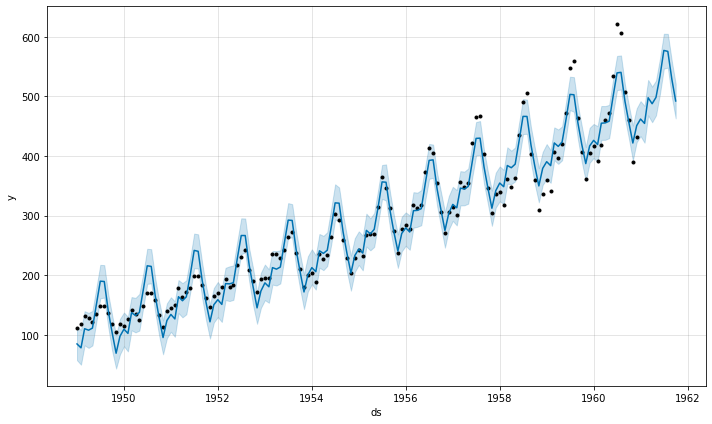

In [42]:
model.plot(forecast)
plt.show()

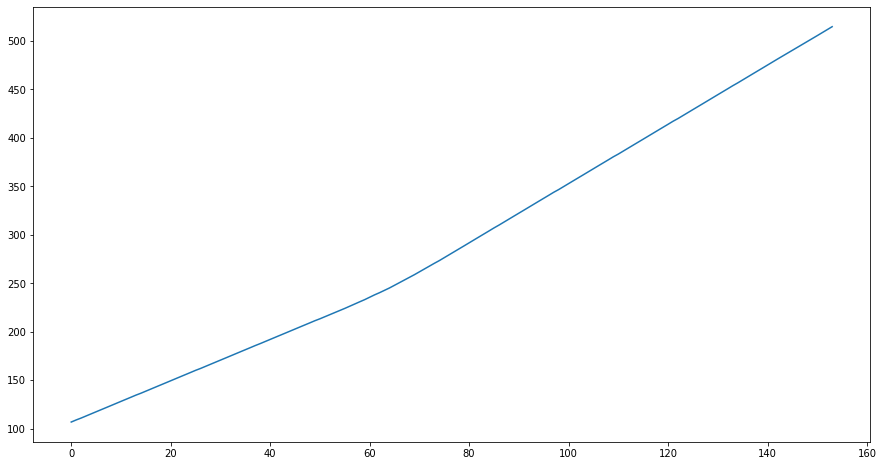

In [46]:
plt.plot(forecast['trend'])